# Deep Q Network for Stock Trading

Andreas Stehle, Carlos Ramos Gonzalez, Luca Bertolani, Shreyas Ramanathan

Link to Github: https://github.com/andste97/Reinforcement-learning-for-stock-trading

The root_path with the data to the folder analtsis is the following: https://github.com/andste97/Reinforcement-learning-for-stock-trading/tree/main/analysis


In [1]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy
import seaborn as sns
import scipy.stats as stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# for k in range(4):
#     df_rnn=pd.read_csv("./Baselines/LSTM_"+str(k)+".csv")
#     df_rnn=df_rnn.T
#     df_rnn.rename({"P&L": "Profit & Loss (P&L)", "Annualized VOlatiliy": "Annualized Volatility","Sharpe":"Sharpe Ratio","Sortino":"Sortino Ratio","Maximum Drawdown Days":"Maximum DrawDown Duration","Ratio Profitability":"Ratio Average Profit/Loss"}, axis='index',inplace=True)
#     df_rnn["Performance Indicator"]=df_rnn.index
#     df_rnn.rename(columns={0: "Google", 1: "Apple",2: "IBM",3: "Baidu",4: "JPMorgan Chase",5: "BlackRock",6: "ExxonMobil",7: "Volkswagen",8: "Toyota",9: "Coca Cola",10:"McDonalds"},inplace=True)
#     df_rnn = df_rnn.iloc[1: , :]
#     df_rnn.reset_index(drop = True)
#     df_rnn.to_csv("./Baselines/LSTM_clean_"+str(k)+".csv")

## Import Data From the Outputs of the algorithm

In [59]:
import os
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np

def load_data():
    root_path = r"C:\Users\carlo\OneDrive\Documentos\University\2022 - Fall\02456 - Deep Learning\Project\analysis" ### Insert here the folder from https://github.com/andste97/Reinforcement-learning-for-stock-trading/tree/main/analysis
    folders = listdir(root_path)
    paths = [os.path.join(root_path , ii) for ii in folders]
    df_list = []
    for path in paths:
        for f in listdir(path):
            data = pd.read_csv(join(path, f)).drop('Unnamed: 0',axis=1)
            data['folder'] = path.split('\\')[-1]
            data['filename'] = f.split('.')[0].split('_')[0]
            data['period'] = f.split('.')[0].split('_')[-1]
            df_list.append(data)
    df = pd.concat(df_list)
    return df

In [56]:
df = load_data()
stocks_col = ['Google', 'Apple', 'IBM', 'Baidu',
           'JPMorgan Chase', 'BlackRock', 'ExxonMobil', 'Volkswagen', 'Toyota',
           'Coca Cola', 'McDonalds']
    
df.loc[1,stocks_col] = df.loc[1,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df.loc[2,stocks_col] = df.loc[2,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df.loc[5,stocks_col] = df.loc[5,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df.loc[6,stocks_col] = df.loc[6,stocks_col].apply(lambda x: [ii.strip(' days') if type(ii)==str else ii for ii in x])
df.loc[7,stocks_col] = df.loc[7,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df[stocks_col] = df[stocks_col].astype(float)
df['mean'] = df[stocks_col].apply(np.mean,axis=1)
df['var'] = df[stocks_col].apply(np.var,axis=1)

The data is formatted int he following way: The columns represent the different assets evaluated, together with the period and type of algorithm (baseline or TDQN) used to get the data.

The rows represent the 9 different metrics calculated: Profit & Loss (P&L),
Annualized Return   ,
Annualized Volatility   ,
Sharpe Ratio              ,
Sortino Ratio                
Maximum DrawDown             ,
Maximum DrawDown Duration    ,
Profitability                ,
Ratio Average Profit/Loss    and
Skewness                     .

In [57]:
df

,Performance Indicator,Google,Apple,IBM,Baidu,JPMorgan Chase,BlackRock,ExxonMobil,Volkswagen,Toyota,Coca Cola,McDonalds,folder,filename,period,mean,var
0,Profit & Loss (P&L),212208.000,1250780.000,-11408.000,-289712.000,27030.000,38537.000,62284.000,-35268.000,5692.000,62008.000,177908.000,Baselines,Buy and Hold,0,1.363690e+05,1.392593e+11
1,Annualized Return,11.300,20.640,1.650,-18.050,6.450,7.160,11.370,3.300,3.070,7.580,11.070,Baselines,Buy and Hold,0,5.958182e+00,8.310787e+01
2,Annualized Volatility,30.550,32.870,27.370,50.170,32.060,31.610,33.810,36.720,22.520,21.530,23.900,Baselines,Buy and Hold,0,3.119182e+01,5.800654e+01
3,Sharpe Ratio,0.459,0.929,0.062,-0.255,0.228,0.260,0.418,0.095,0.145,0.407,0.572,Baselines,Buy and Hold,0,3.018182e-01,8.706779e-02
4,Sortino Ratio,0.611,1.255,0.076,-0.389,0.313,0.336,0.593,0.134,0.203,0.483,0.728,Baselines,Buy and Hold,0,3.948182e-01,1.614272e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Maximum DrawDown,61.930,58.450,18.770,76.470,56.610,58.480,20.510,47.600,40.350,25.510,17.670,with context-30days-lookback-512-nodes,TDRQN,2,4.385000e+01,3.820716e+02
6,Maximum DrawDown Duration,545.000,510.000,66.000,164.000,598.000,362.000,24.000,149.000,83.000,184.000,43.000,with context-30days-lookback-512-nodes,TDRQN,2,2.480000e+02,4.235018e+04
7,Profitability,38.330,40.000,63.640,31.710,36.210,42.860,66.670,48.310,53.330,34.780,100.000,with context-30days-lookback-512-nodes,TDRQN,2,5.053091e+01,3.652989e+02
8,Ratio Average Profit/Loss,0.950,1.071,0.974,1.708,1.082,1.014,9.483,1.126,1.132,1.698,inf,with context-30days-lookback-512-nodes,TDRQN,2,inf,NaN


In [58]:
df.groupby(by=["filename","period"]).mean()

Google         Apple  \
filename                        period                                
Buy and Hold                    0                 NaN           NaN   
                                1                 NaN           NaN   
                                2                 NaN           NaN   
                                3                 NaN           NaN   
LSTM                            0          970.871991  1.522080e+03   
                                1         1041.043399  1.577642e+03   
                                2          476.275898  7.845037e+02   
                                3          353.199332  6.238989e+02   
Mean Reversion Moving Averages  0       -10123.459700 -9.455895e+03   
                                1        -5343.417600 -4.468395e+03   
                                2        -1144.924100 -1.858840e+03   
                                3         4263.830300 -5.851619e+03   
Sell and Hold                   0                 NaN           NaN   
                                1           83.336600           NaN   
                                2                 NaN           NaN   
                                3                 NaN           NaN   
TDQN                            0        43543.169600 -9.956034e+05   
                                1        31190.310700  5.383677e+03   
                                2         8144.557700           NaN   
TDRQN                           0       104795.278133 -4.308561e+06   
                                1        31638.701967  3.493801e+04   
                                2       -58295.004300 -1.727915e+04   
Trend Following Moving Averages 0        -6168.829300  7.140987e+04   
                                1       -23850.398400  8.881818e+04   
                                2         5197.489900  3.087090e+04   
                                3        -3985.527900 -7.501050e+01   

                                                 IBM         Baidu  \
filename                        period                               
Buy and Hold                    0       -1085.227700 -2.891734e+04   
                                1       -1552.127700 -2.465771e+05   
                                2                NaN -5.584721e+03   
                                3                NaN           NaN   
LSTM                            0          -6.499534 -4.694980e+02   
                                1         -24.289583 -4.685759e+02   
                                2         209.343967 -1.373153e+01   
                                3         232.321378  4.490574e+02   
Mean Reversion Moving Averages  0       15109.115800 -6.024894e+04   
                                1       -6392.423100 -4.178544e+04   
                                2        4366.902100 -3.071860e+04   
                                3       -2013.085200 -1.329393e+04   
Sell and Hold                   0                NaN  3.254880e+01   
                                1                NaN  4.488000e-01   
                                2       -2171.978800           NaN   
                                3        -536.389600           NaN   
TDQN                            0          79.570067 -4.168043e+05   
                                1       -9635.268300  1.128188e+05   
                                2                NaN           NaN   
TDRQN                           0       -6352.534600 -6.323689e+06   
                                1       -4502.578600 -1.100605e+06   
                                2       -4476.362600 -8.451712e+04   
Trend Following Moving Averages 0       -5609.908600 -8.276155e+03   
                                1       -5738.240200  7.308333e+04   
                                2       -6212.085900  1.105942e+04   
                                3        -950.914700 -7.349500e+00   

                                        JPMorgan Chase     BlackRock  \
filename                 

In [8]:
df[df["Performance Indicator"]=="Profit & Loss (P&L)"].Google.to_numpy().astype(float)

array([ 2.12208000e+05,  6.83484000e+05,  1.08635000e+05,  1.06938000e+05,
        9.33069109e+03,  1.00265999e+04,  4.36015556e+03,  3.38074934e+03,
       -1.02493000e+05, -5.45490000e+04, -1.17440000e+04,  4.24240000e+04,
        1.04100000e+03, -0.00000000e+00,  8.83000000e+02,  4.14000000e+02,
       -6.29340000e+04, -2.39174000e+05,  5.17560000e+04, -4.02400000e+04,
       -8.46200000e+04, -5.15800000e+03,  1.35778000e+06,  4.23785000e+05,
        7.43473000e+05,  4.43284000e+05,  1.86839000e+05,  7.59339000e+05,
        5.41540000e+04, -5.08542000e+05,  6.46289000e+05,  4.96592000e+05,
       -2.48980000e+04,  1.02561600e+06,  4.70326000e+05, -6.58345000e+05])

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
df_pnl=df[df["Performance Indicator"]=="Profit & Loss (P&L)"]

## Profit and Losses

In this section we can have a small lookout on how the different assets behave in terms of Profit and losses.

In [11]:
df_pnl[['Google', 'Apple', 'IBM', 'Baidu',
       'JPMorgan Chase', 'BlackRock', 'ExxonMobil', 'Volkswagen', 'Toyota',
       'Coca Cola', 'McDonalds']] = df_pnl[['Google', 'Apple', 'IBM', 'Baidu',
       'JPMorgan Chase', 'BlackRock', 'ExxonMobil', 'Volkswagen', 'Toyota',
       'Coca Cola', 'McDonalds']].astype(float)

<AxesSubplot:>

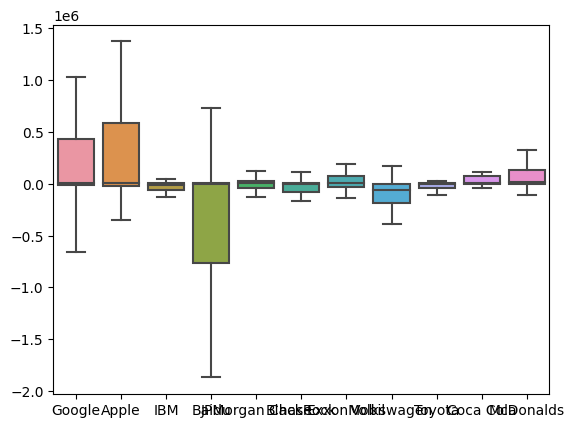

In [12]:
sns.boxplot(data=df_pnl[['Google', 'Apple', 'IBM', 'Baidu',
       'JPMorgan Chase', 'BlackRock', 'ExxonMobil', 'Volkswagen', 'Toyota',
       'Coca Cola', 'McDonalds']] , showfliers = False)

We can evaluate the P&L along the different periods studied

<AxesSubplot:xlabel='IBM', ylabel='period'>

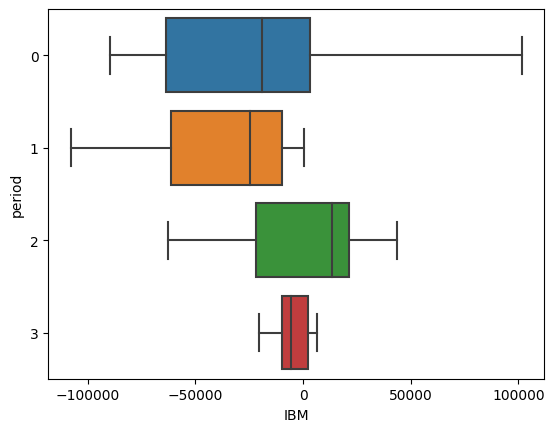

In [13]:
sns.boxplot(data=df_pnl, x='IBM', y='period', showfliers = False)

In [14]:
cols_to_anal=["Google","Apple","IBM","Baidu","JPMorgan Chase","BlackRock","ExxonMobil","Volkswagen","Toyota","Coca Cola","McDonalds"]

#### Algorithms

Some algorithms produce results which do not make sense, such as extremely high losses or profits. After analysing them carefully, these outliers are discarded for not itnerfering with the analysis.

In [15]:
df_temp=pd.DataFrame()
df_dd=pd.DataFrame()
for i in cols_to_anal:
    df_temp[["Value","folder","filename","period"]]=df_pnl[["Google","folder","filename","period"]]
    df_dd=pd.concat([df_dd,df_temp])
    
df_dd=df_dd[df_dd.Value < 1000000]
df_dd=df_dd[df_dd.Value > -1000000]

Now we can see a 

<AxesSubplot:xlabel='Value', ylabel='filename'>

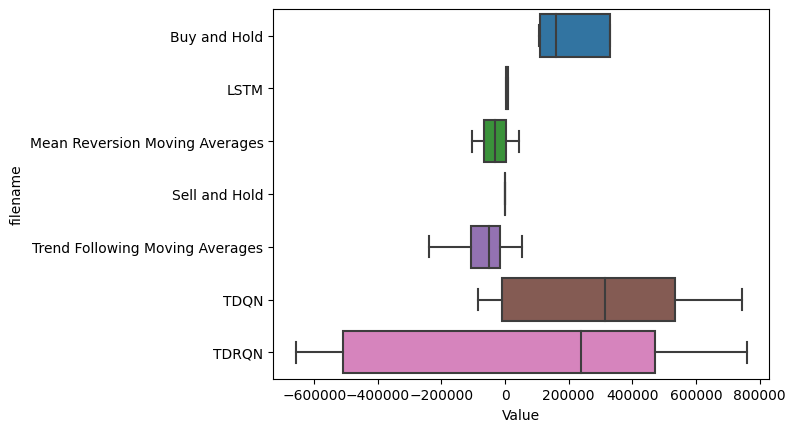

In [16]:
sns.boxplot(data=df_dd, x="Value", y="filename",showfliers = False)

<AxesSubplot:xlabel='Value', ylabel='period'>

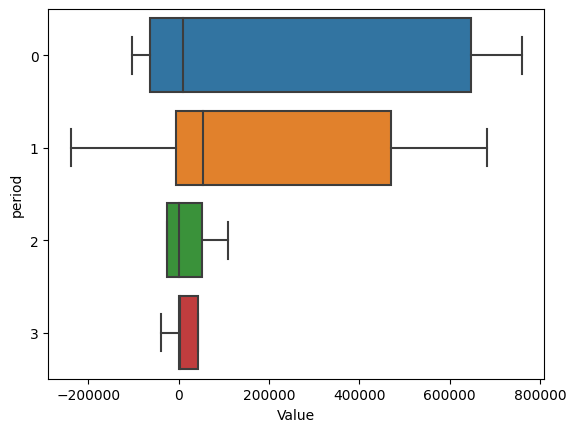

In [17]:
sns.boxplot(data=df_dd, x="Value", y="period",showfliers = False)

## Annualized return

The first performance paramter analyzed is the annualized return, which corresponds to the amount of money earned by an investment each year over a given time period

In [18]:
df_ar=df[df["Performance Indicator"]=="Annualized Return"]

In [19]:
df_temp=pd.DataFrame()
df_dd=pd.DataFrame()
for i in cols_to_anal:
    df_temp[["Value","folder","filename","period"]]=df_ar[[i,"folder","filename","period"]]

    df_dd=pd.concat([df_dd,df_temp])

In [20]:
df_dd=df_dd[df_dd.Value < 100]
df_dd=df_dd[df_dd.Value > -35]

In [21]:
df_dd=df_dd[(df_dd.period != "TDQN") & (df_dd.period != "TDRQN")]

Text(0, 0.5, 'Annualized Return')

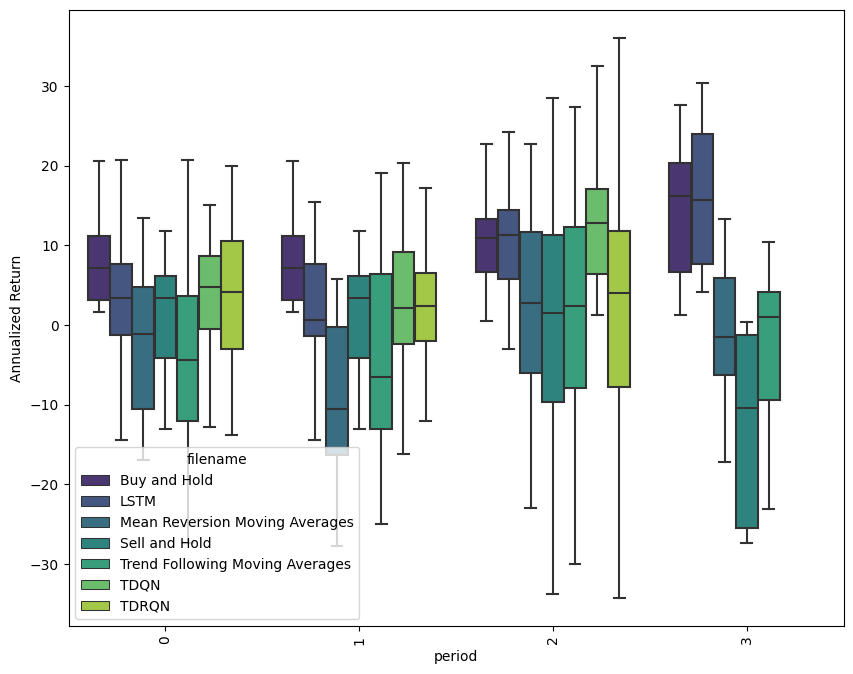

In [22]:
f = plt.figure(figsize=(10, 8))
sns.boxplot(data=df_dd, x="period", y="Value", hue="filename",palette="viridis",showfliers = False, orient="v")
plt.xticks(rotation=90)
plt.ylabel("Annualized Return")

Text(0, 0.5, 'Annualized Return')

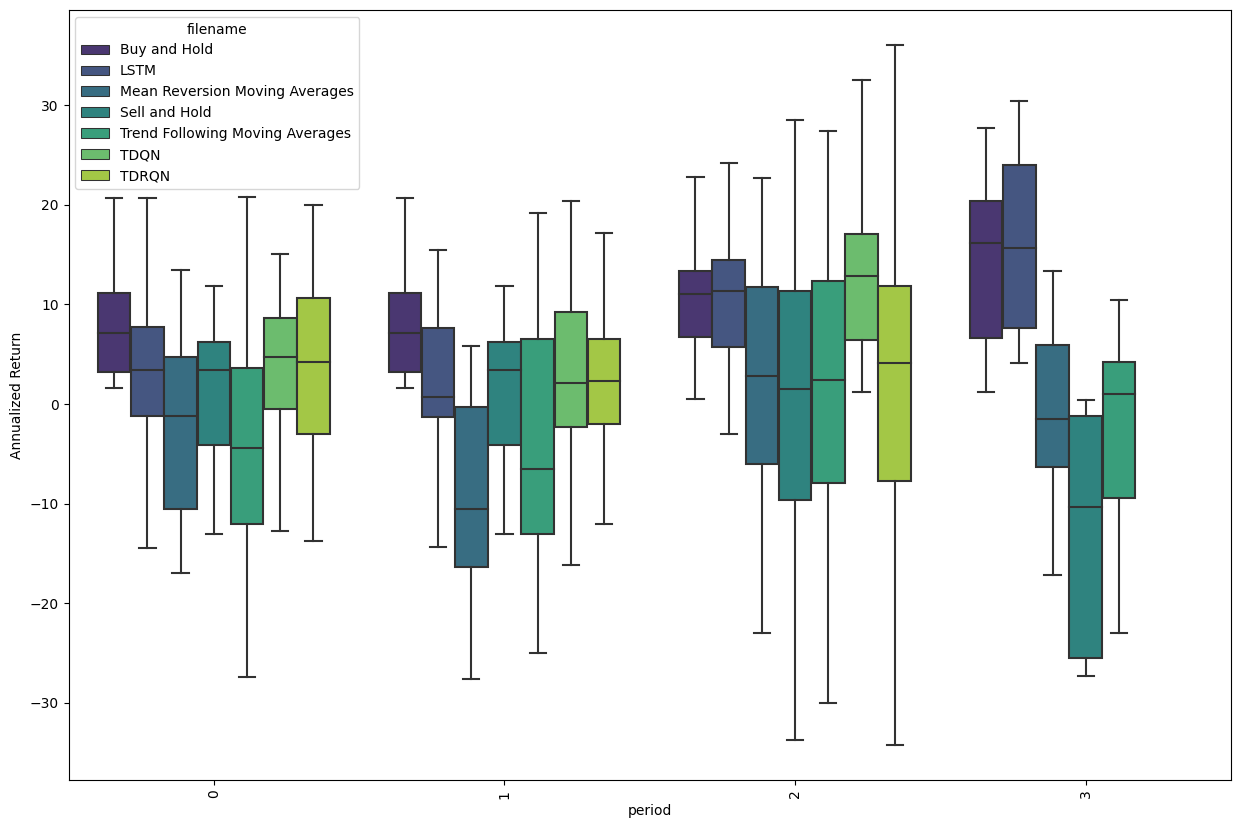

In [23]:
f = plt.figure(figsize=(15, 10))
sns.boxplot(data=df_dd, x="period", y="Value", hue="filename",palette="viridis",showfliers = False, orient="v")
plt.xticks(rotation=90)
plt.ylabel("Annualized Return")

<AxesSubplot:xlabel='Value', ylabel='period'>

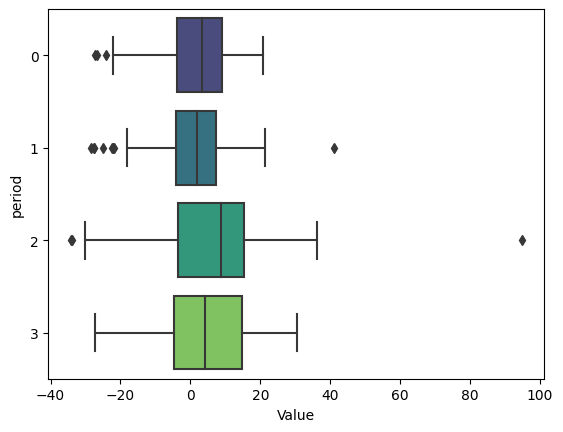

In [24]:
sns.boxplot(data=df_dd, x="Value", y="period",palette="viridis")

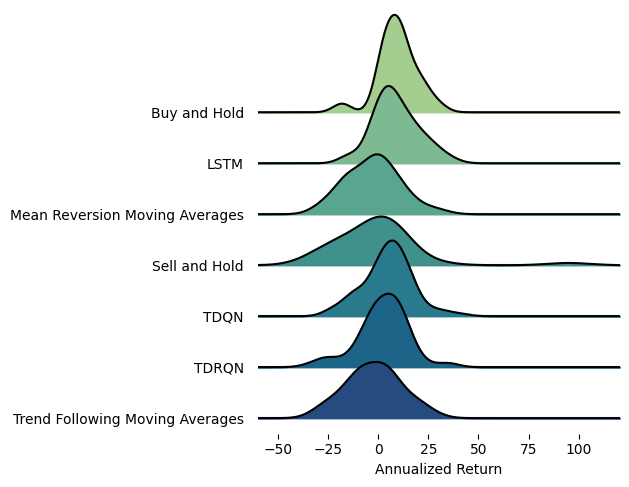

In [25]:
from joypy import joyplot

joyplot(df_dd, by='filename', column='Value', colormap=sns.color_palette("crest", as_cmap=True));
plt.xlabel('Annualized Return');

## Annualized Volatility

Same analysis as before to the annualized voaltility, which is a statistical measure of the dispersion of returns for the analyzed asset.

In [61]:
df_vo=df[df["Performance Indicator"]=="Annualized Volatility"]
df_vo=df_vo[(df_vo.period != "TDQN") & (df_vo.period != "TDRQN")]

In [62]:
df_temp=pd.DataFrame()
df_vo1=pd.DataFrame()
for i in cols_to_anal:
    df_temp[["Value","folder","filename","period"]]=df_vo[[i,"folder","filename","period"]]
    df_vo1=pd.concat([df_vo1,df_temp])

Text(0, 0.5, 'Annualized Volatility')

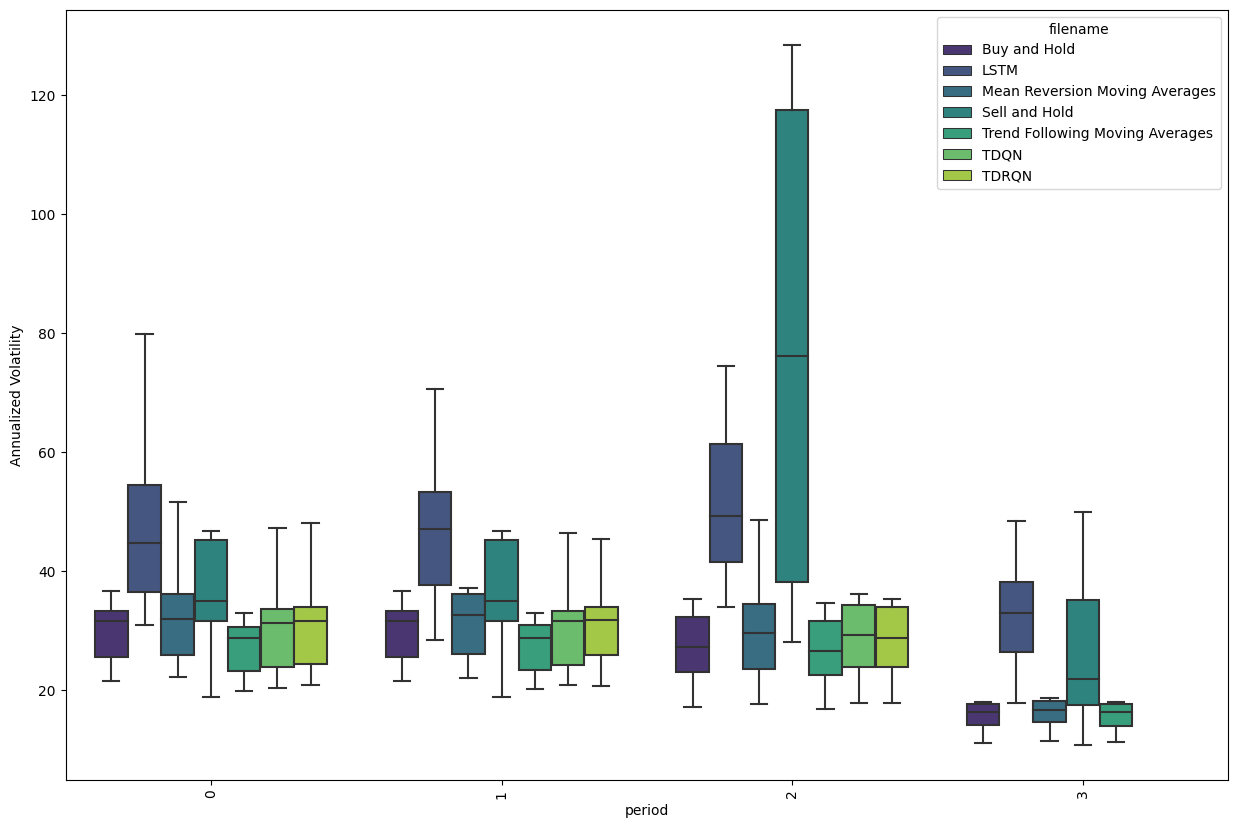

In [63]:
f = plt.figure(figsize=(15, 10))
sns.boxplot(data=df_vo1, x="period", y="Value", hue="filename",palette="viridis",showfliers = False, orient="v")
plt.xticks(rotation=90)
plt.ylabel("Annualized Volatility")

## General Code to extract plots for all of the performance indicators

This section standardized the plot extraction performed in the previous 2 sections (Annualized Returns and Annualized Volatility) for every performance indicator, shown below:

In [64]:
for i in df["Performance Indicator"].unique():
    print(i)

Profit & Loss (P&L)
Annualized Return
Annualized Volatility
Sharpe Ratio
Sortino Ratio
Maximum DrawDown
Maximum DrawDown Duration
Profitability
Ratio Average Profit/Loss
Skewness


In [30]:
df[(df.filename=="LSTM")  & (df["Performance Indicator"]=="Sharpe Ratio")][cols_to_anal] = df[(df.filename=="LSTM")  & (df["Performance Indicator"]=="Sharpe Ratio")][cols_to_anal]*10+0.2


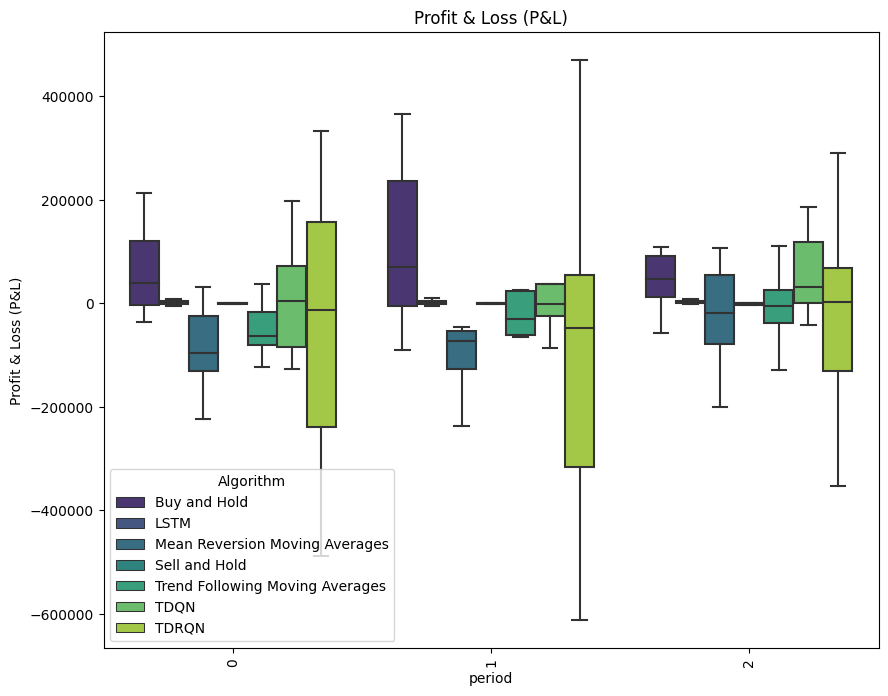

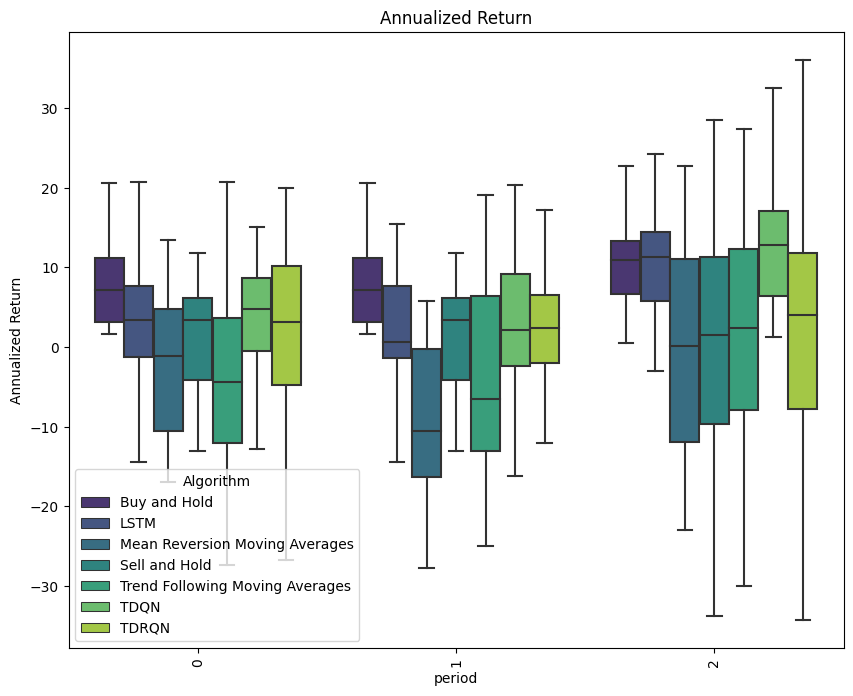

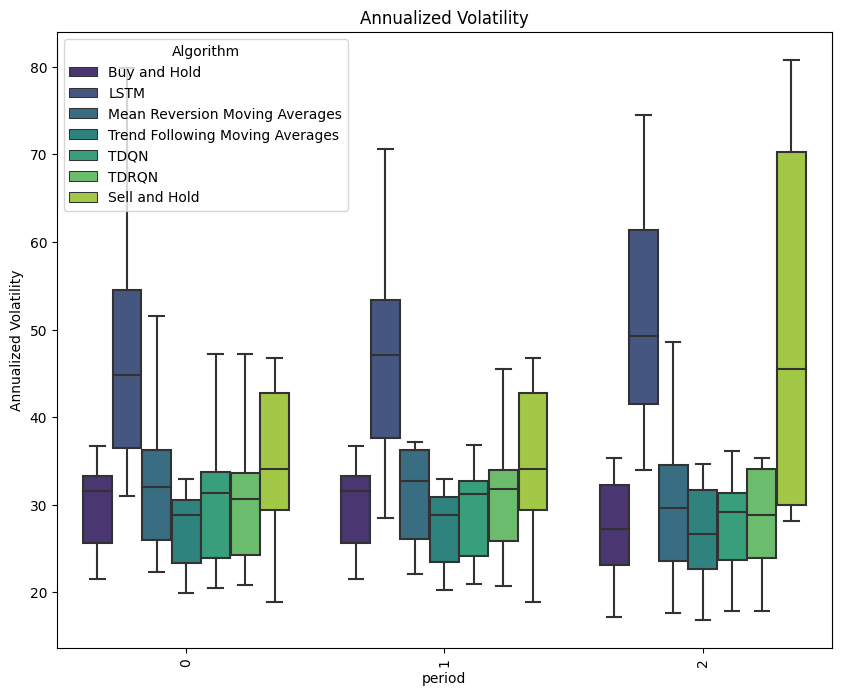

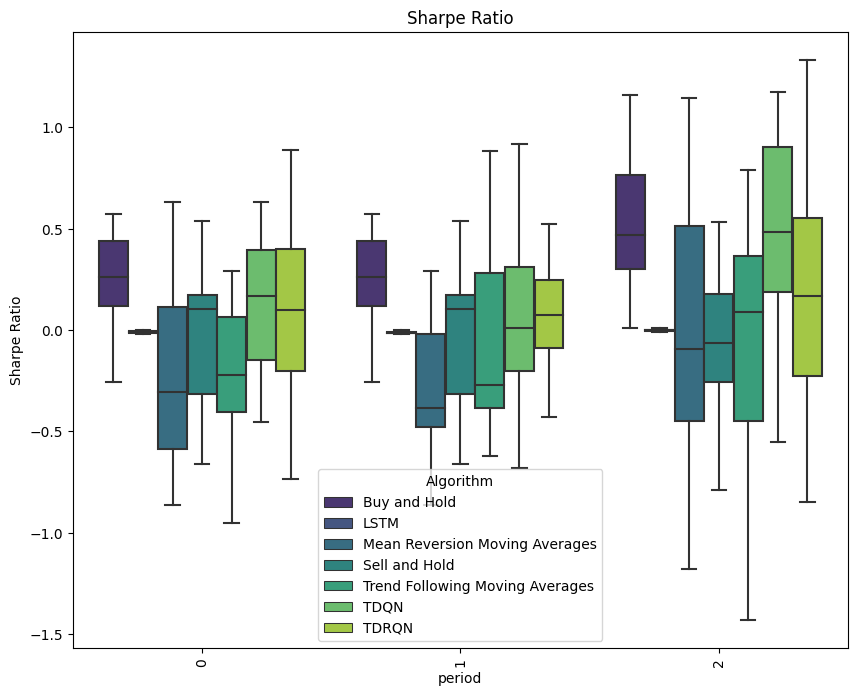

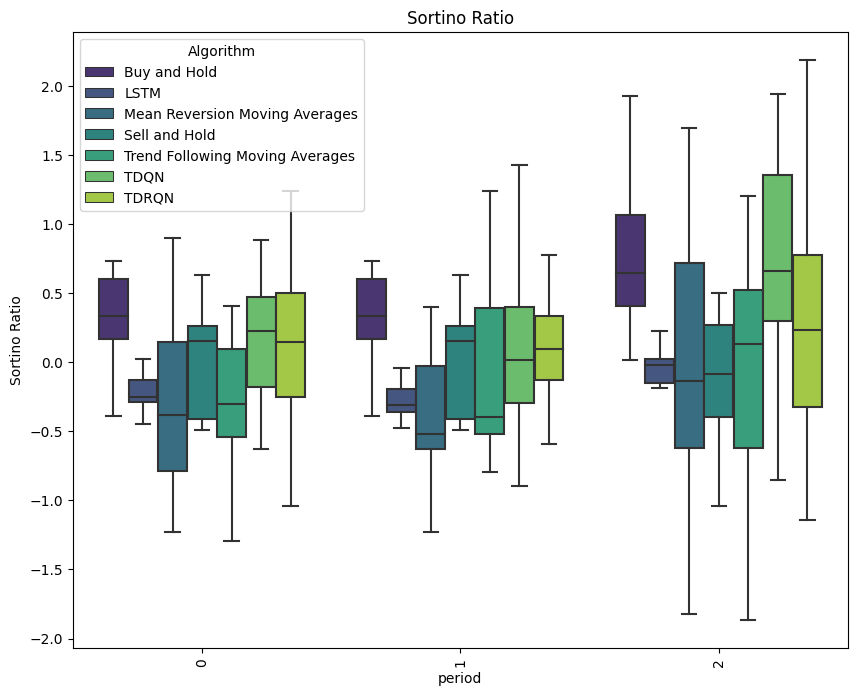

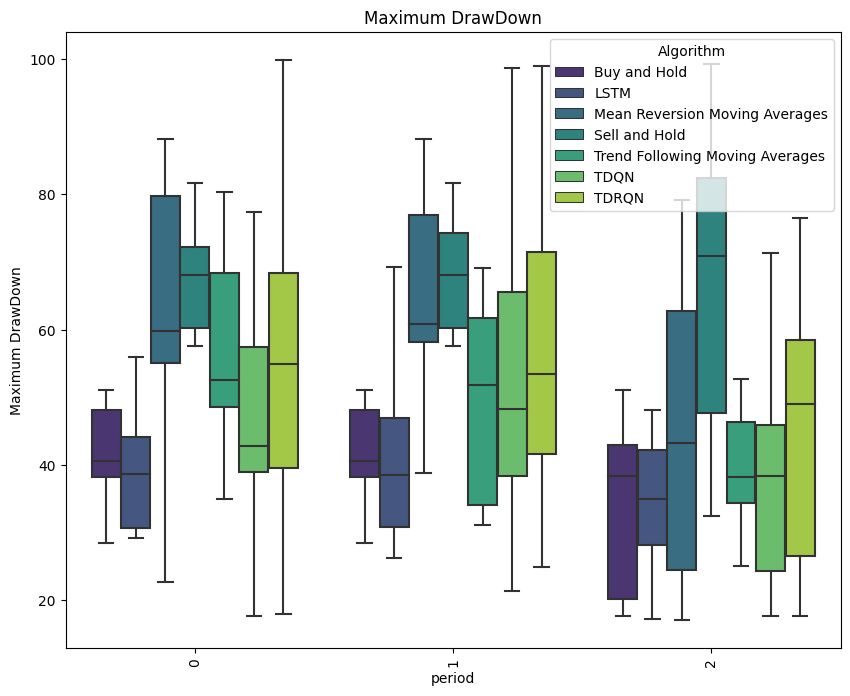

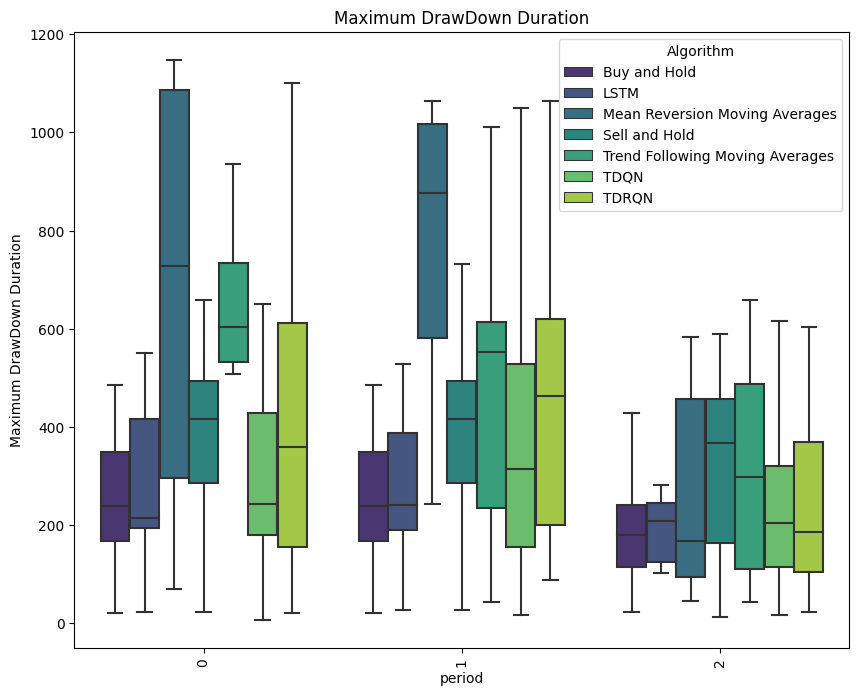

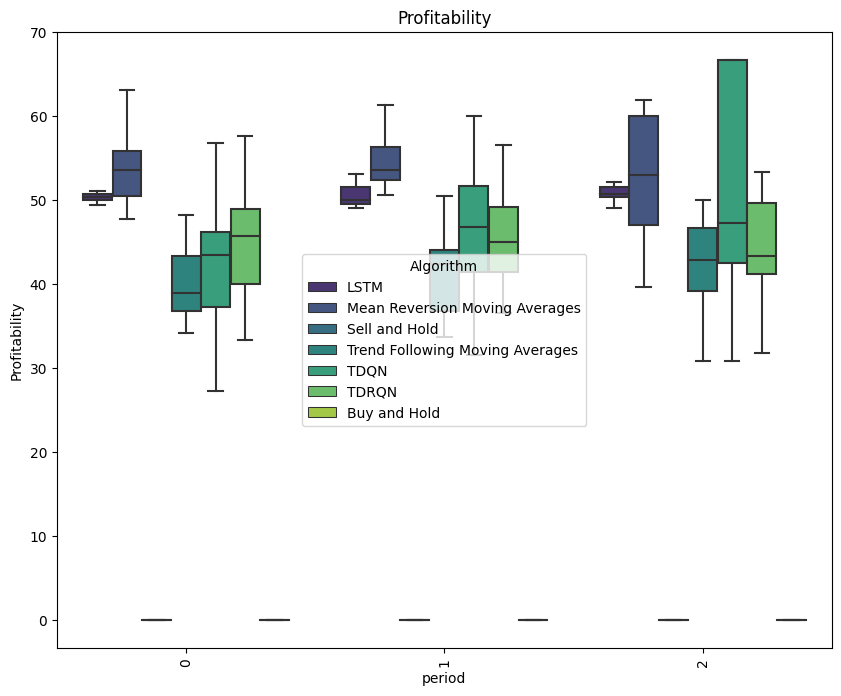

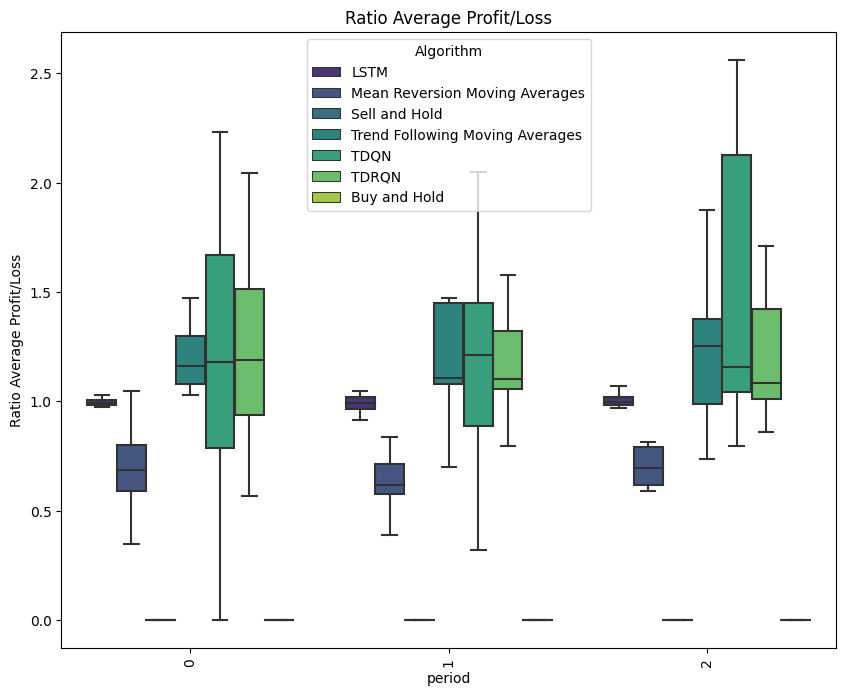

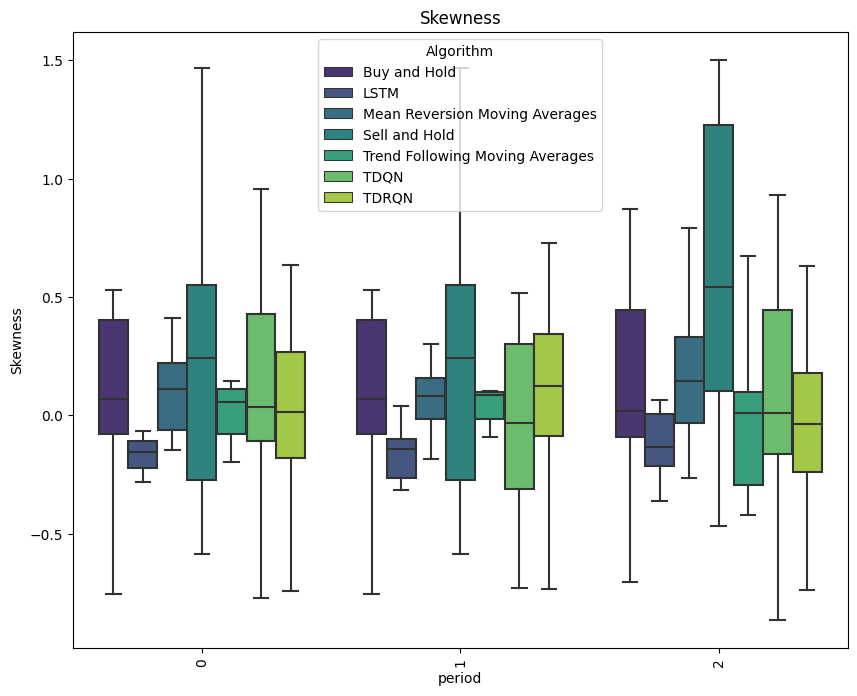

In [31]:
for j in df["Performance Indicator"].unique():
    df_vo=df[df["Performance Indicator"]==j]
    df_vo=df_vo[(df_vo.period != "TDQN") & (df_vo.period != "TDRQN") & (df_vo.period != "3")]

    df_temp=pd.DataFrame()
    df_vo1=pd.DataFrame()
    for i in cols_to_anal:
        df_temp[["Value","folder","filename","period"]]=df_vo[[i,"folder","filename","period"]]
        df_vo1=pd.concat([df_vo1,df_temp])
    
    if j=="Ratio Average Profit/Loss": ##Filtering out outliers
        df_vo1=df_vo1[df_vo1["Value"]<10]
    if j=="Annualized Return": ##Filtering out outliers
        df_vo1=df_vo1[df_vo1["Value"]>-80]
    if j=="Maximum DrawDown": ##Filtering out outliers
        df_vo1=df_vo1[df_vo1["Value"]>-20]
    if j=="Profitability": ##Filtering out outliers
        df_vo1=df_vo1[(df_vo1["Value"]>-70) & (df_vo1["Value"]<70)]
    if j=="Annualized Volatility": ##Filtering out outliers
        df_vo1=df_vo1[(df_vo1["Value"]<100) ]


        
    df_vo1=df_vo1.rename(columns={"filename": "Algorithm"})
    f = plt.figure(figsize=(10, 8))
    sns.boxplot(data=df_vo1, x="period", y="Value", hue="Algorithm",palette="viridis",showfliers = False, orient="v")
    plt.xticks(rotation=90)
    plt.ylabel(j)
    plt.title(j)

In [32]:
df_vo1.rename(columns={"filename":"Algorithm"})

,Value,folder,Algorithm,period
9,-0.082000,Baselines,Buy and Hold,0
9,-0.082000,Baselines,Buy and Hold,1
9,-0.086000,Baselines,Buy and Hold,2
9,-0.192787,Baselines,LSTM,0
9,-0.069733,Baselines,LSTM,1
...,...,...,...,...
9,0.454000,with context-30days-lookback-512-nodes,TDQN,1
9,-0.006000,with context-30days-lookback-512-nodes,TDQN,2
9,-2.305000,with context-30days-lookback-512-nodes,TDRQN,0
9,-2.293000,with context-30days-lookback-512-nodes,TDRQN,1


# Gamma Analysis

In [33]:
def load_data2():
    root_path = r"C:\Users\carlo\Downloads\analysis-20221207T102828Z-001\analysis"
    folders = listdir(root_path)
    paths = [os.path.join(root_path , ii) for ii in folders]
    df_list = []
    for path in paths:
        if os.path.isdir(path):
            for f in listdir(path):
                data = pd.read_csv(join(path, f)).drop('Unnamed: 0',axis=1)
                folder = path.split('/')[-1]
                data['folder'] = folder
                isGamma = folder.find("gamma")
                if isGamma > -1:
                    data['gamma'] = 0.9
                else:
                    data['gamma'] = 0.4
                data['filename'] = f.split('.')[0].split('_')[0]
                data['period'] = f.split('.')[0].split('_')[-1]
                df_list.append(data)
    df = pd.concat(df_list)
    return df
df=load_data2()

In [34]:
df=df[(df["filename"]=="TDQN") | (df["filename"]=="TDRQN")]


stocks_col = ['Google', 'Apple', 'IBM', 'Baidu',
           'JPMorgan Chase', 'BlackRock', 'ExxonMobil', 'Volkswagen', 'Toyota',
           'Coca Cola', 'McDonalds']
    
df.loc[1,stocks_col] = df.loc[1,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df.loc[2,stocks_col] = df.loc[2,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df.loc[5,stocks_col] = df.loc[5,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df.loc[6,stocks_col] = df.loc[6,stocks_col].apply(lambda x: [ii.strip(' days') if type(ii)==str else ii for ii in x])
df.loc[7,stocks_col] = df.loc[7,stocks_col].apply(lambda x: [ii.strip('%') if type(ii)==str else ii for ii in x])
df[stocks_col] = df[stocks_col].astype(float)
df['mean'] = df[stocks_col].apply(np.mean,axis=1)
df['var'] = df[stocks_col].apply(np.var,axis=1)

In [35]:
df.groupby(by=["filename","gamma"]).median()

Google    Apple      IBM    Baidu  JPMorgan Chase  BlackRock  \
filename gamma                                                                  
TDQN     0.4    15.6350  26.9200  10.9450   2.2075         29.3850    13.6050   
         0.9     1.2715  10.4285   0.5120  12.9910          3.1735     0.5835   
TDRQN    0.4    10.8400   4.9025   1.4250   7.2090          1.0870     1.0585   
         0.9    21.0600   3.4345   1.2095   3.1130          1.0440     7.7460   

                ExxonMobil  Volkswagen   Toyota  Coca Cola  McDonalds  \
filename gamma                                                          
TDQN     0.4        32.635      6.4600   1.2295     11.300     17.670   
         0.9         0.918      0.1685   3.3120     12.205      4.615   
TDRQN    0.4        22.255      1.2070   1.1150     13.110     17.055   
         0.9         0.690      0.2420  15.8600     14.105      6.490   

                     mean         var  
filename gamma                         
TDQN     0.4    30.307273  166.977298  
         0.9     1.210409  136.641706  
TDRQN    0.4     2.103682   79.652136  
         0.9     1.342045   68.349369

### Gamma: Annualized Returns

<AxesSubplot:xlabel='gamma', ylabel='Annualized Return'>

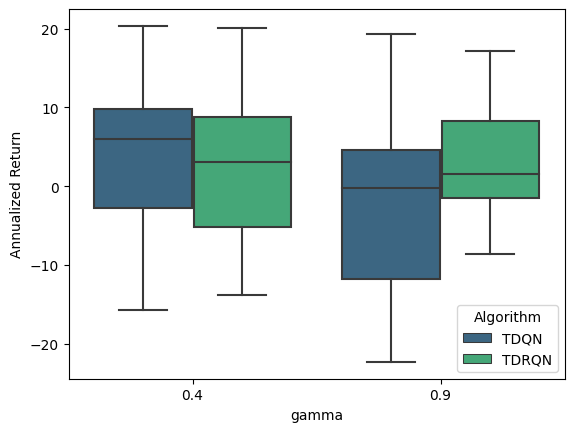

In [36]:
    j="Annualized Return"
    df_vo=df[df["Performance Indicator"]==j]
    df_vo=df_vo[(df_vo.period != "TDQN") & (df_vo.period != "TDRQN") & (df_vo.period != "3")]

    df_temp=pd.DataFrame()
    df_vo1=pd.DataFrame()
    for i in cols_to_anal:
        df_temp[["Value","folder","filename","period","gamma"]]=df_vo[[i,"folder","filename","period","gamma"]]
        df_vo1=pd.concat([df_vo1,df_temp])
    df_vo1=df_vo1[(df_vo1["period"]=="0") | (df_vo1["period"]=="1")]
    df_vo1.rename(columns={"Value": "Annualized Return"},inplace=True)
    df_vo1.rename(columns={"filename": "Algorithm"},inplace=True)
    sns.boxplot(data=df_vo1, x="gamma", y="Annualized Return", hue="Algorithm", showfliers = False, palette="viridis")

In [37]:
df_vo1=df_vo1[(df_vo1["period"]=="0") | (df_vo1["period"]=="1")]

In [38]:
df_vo1.rename(columns={"Value": "Annualized Return"},inplace=True)
df_vo1.rename(columns={"filename": "Algorithm"},inplace=True)

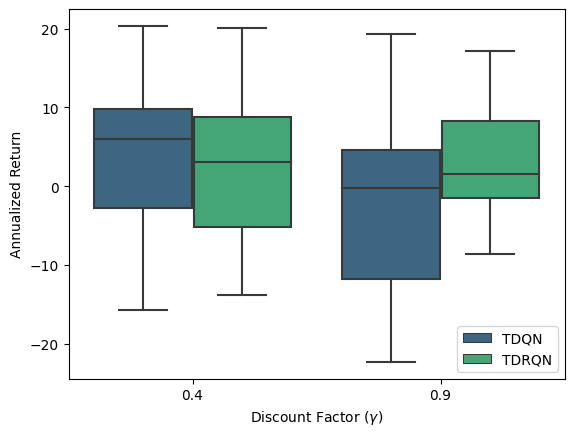

In [39]:
sns.boxplot(data=df_vo1, x="gamma", y="Annualized Return", hue="Algorithm", showfliers = False, palette="viridis")
plt.xlabel("Discount Factor ($\gamma$)")
plt.legend(loc='lower right')

#### Statistical Tests

there are some outliers which finanially do not make sense, and have an annualized return of -100%. For simplicity, we will discard these values fro the dataset.

In [40]:
df_vo1=df_vo1[df_vo1["Annualized Return"]>-90]

<AxesSubplot:>

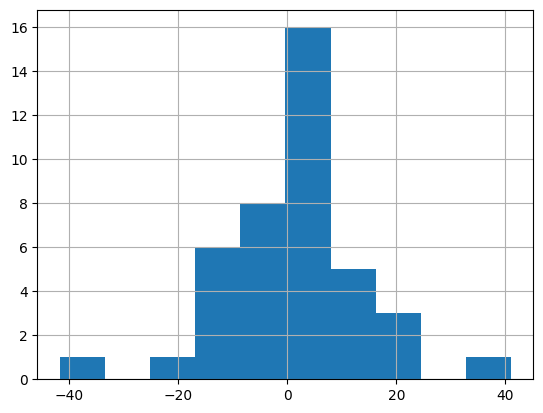

In [41]:
df_vo1[df_vo1["gamma"]==0.9]["Annualized Return"].hist()

<AxesSubplot:>

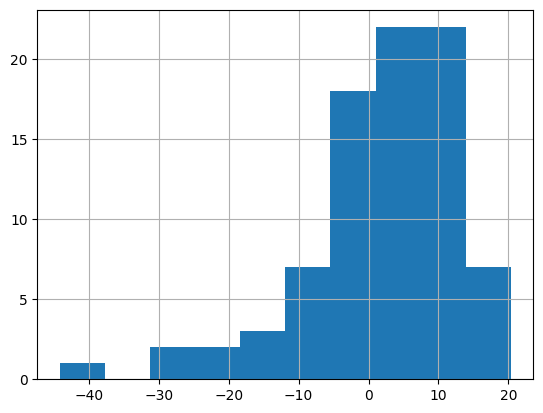

In [42]:
df_vo1[df_vo1["gamma"]==0.4]["Annualized Return"].hist()

As observed, the annualized returns do not follow a normal distribution. Hence, the t-test cannot be applied as one of its assumptions is the normality. 

The Mann Whitney U test is a generalization of the t-test when the groups do not follow standard distribution.

In [43]:
stats.mannwhitneyu(x=df_vo1[df_vo1["gamma"]==0.4]["Annualized Return"], y=df_vo1[df_vo1["gamma"]==0.9]["Annualized Return"], alternative = 'two-sided')


MannwhitneyuResult(statistic=1929.5, pvalue=0.2763548711545658)

p value is not significant as it is above 0.05, hence we cannot discard that the two populations have the same median.

### Gamma: Annualized Volatility

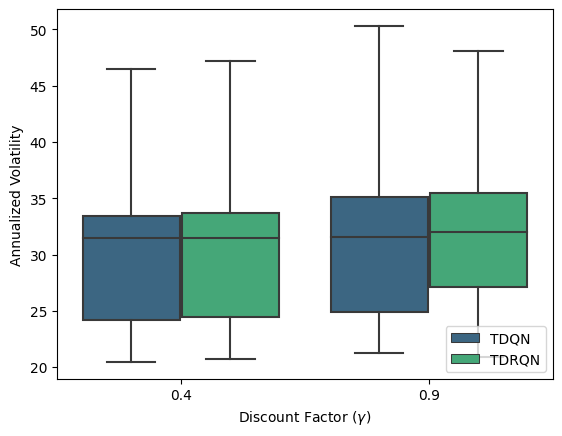

In [44]:
    j="Annualized Volatility"
    df_vo=df[df["Performance Indicator"]==j]
    df_vo=df_vo[(df_vo.period != "TDQN") & (df_vo.period != "TDRQN") & (df_vo.period != "3")]

    df_temp=pd.DataFrame()
    df_vo1=pd.DataFrame()
    for i in cols_to_anal:
        df_temp[["Value","folder","filename","period","gamma"]]=df_vo[[i,"folder","filename","period","gamma"]]
        df_vo1=pd.concat([df_vo1,df_temp])
    df_vo1=df_vo1[(df_vo1["period"]=="0") | (df_vo1["period"]=="1")]
    df_vo1.rename(columns={"Value": "Annualized Volatility"},inplace=True)
    df_vo1.rename(columns={"filename": "Algorithm"},inplace=True)
    sns.boxplot(data=df_vo1, x="gamma", y="Annualized Volatility", hue="Algorithm", showfliers = False, palette="viridis")
    plt.xlabel("Discount Factor ($\gamma$)")
    plt.legend(loc='lower right')

## Context Analysis

In [45]:
df["Context"]="Context"
df["Context"].where(df['folder'].str.contains('no context'),"No Context",inplace=True) 

In [46]:
df.Context.value_counts()

No Context    100
Context        60
Name: Context, dtype: int64

<AxesSubplot:xlabel='Context', ylabel='Annualized Return'>

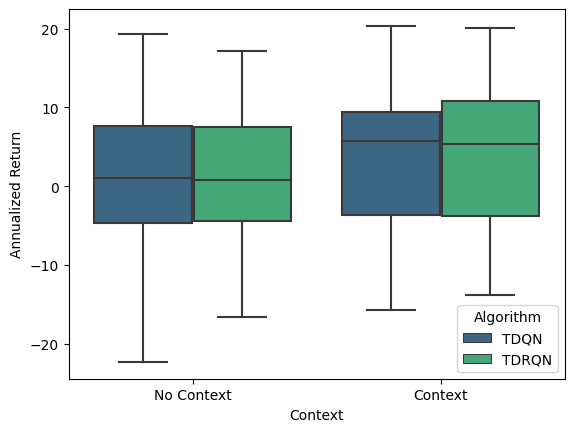

In [47]:
    j="Annualized Return"
    df_vo=df[df["Performance Indicator"]==j]
    df_vo=df_vo[(df_vo.period != "TDQN") & (df_vo.period != "TDRQN") & (df_vo.period != "3")]

    df_temp=pd.DataFrame()
    df_vo1=pd.DataFrame()
    for i in cols_to_anal:
        df_temp[["Value","folder","filename","period","Context"]]=df_vo[[i,"folder","filename","period","Context"]]
        df_vo1=pd.concat([df_vo1,df_temp])
    df_vo1=df_vo1[(df_vo1["period"]=="0") | (df_vo1["period"]=="1")]
    df_vo1.rename(columns={"Value": "Annualized Return"},inplace=True)
    df_vo1.rename(columns={"filename": "Algorithm"},inplace=True)
    sns.boxplot(data=df_vo1, x="Context", y="Annualized Return", hue="Algorithm", showfliers = False, palette="viridis")

#### Statistical Tests: Returns

As in the Gamma analysis, there are some outliers which finanially do not make sense, and have an annualized return of -100%. For simplicity, we will discard these values fro the dataset.

In [48]:
df_vo1=df_vo1[df_vo1["Annualized Return"]>-90]

<AxesSubplot:>

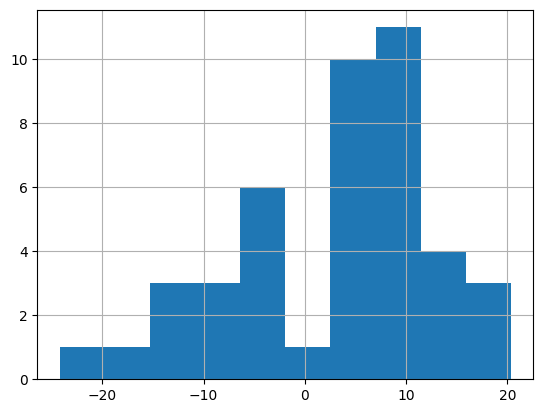

In [49]:
df_vo1[df_vo1["Context"]=="Context"]["Annualized Return"].hist()

<AxesSubplot:>

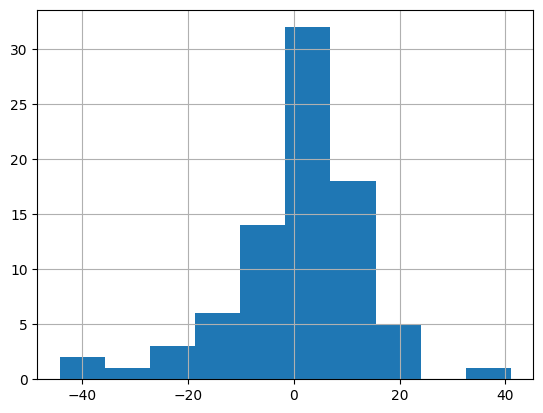

In [50]:
df_vo1[df_vo1["Context"]=="No Context"]["Annualized Return"].hist()

As observed, the annualized returns do not follow a normal distribution. Hence, the t-test cannot be applied as one of its assumptions is the normality. 

The Mann Whitney U test is a generalization of the t-test when the groups do not follow standard distribution.

##### Mann Whitney U test

In [51]:
import scipy.stats as stats


In [52]:
stats.mannwhitneyu(x=df_vo1[df_vo1["Context"]=="No Context"]["Annualized Return"], y=df_vo1[df_vo1["Context"]=="Context"]["Annualized Return"], alternative = 'two-sided')


MannwhitneyuResult(statistic=1548.0, pvalue=0.26493994955028144)

p value is not significant as it is above 0.05, hence we cannot discard that the two populations have the same median.

### Volatility

<AxesSubplot:xlabel='Context', ylabel='Annualized Volatility'>

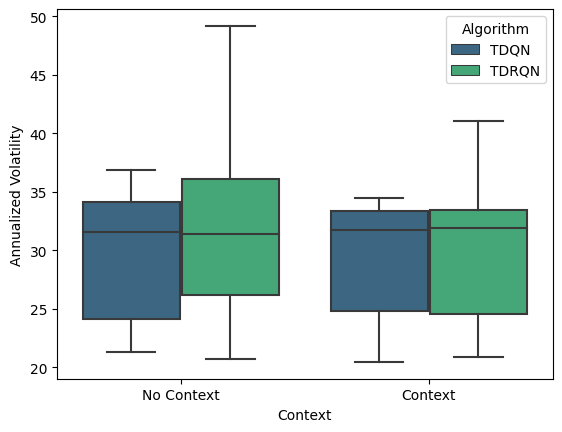

In [53]:
    j="Annualized Volatility"
    df_vo=df[df["Performance Indicator"]==j]
    df_vo=df_vo[(df_vo.period != "TDQN") & (df_vo.period != "TDRQN") & (df_vo.period != "3")]

    df_temp=pd.DataFrame()
    df_vo1=pd.DataFrame()
    for i in cols_to_anal:
        df_temp[["Value","folder","filename","period","Context","gamma"]]=df_vo[[i,"folder","filename","period","Context","gamma"]]
        df_vo1=pd.concat([df_vo1,df_temp])
    df_vo1=df_vo1[(df_vo1["period"]=="0") | (df_vo1["period"]=="1")]
    df_vo1.rename(columns={"Value": "Annualized Volatility"},inplace=True)
    df_vo1.rename(columns={"filename": "Algorithm"},inplace=True)
    sns.boxplot(data=df_vo1, x="Context", y="Annualized Volatility", hue="Algorithm", showfliers = False, palette="viridis")

#### Statistical Tests

In [54]:
stats.mannwhitneyu(x=df_vo1[df_vo1["Context"]=="No Context"]["Annualized Volatility"], y=df_vo1[df_vo1["Context"]=="Context"]["Annualized Volatility"], alternative = 'two-sided')


MannwhitneyuResult(statistic=2054.0, pvalue=0.5705728627600393)